# Agent DQN Replay

- Creation : 22/03/2025

PoC en exploitant la version DQN de l'exercice 2.7 .

## Modules

In [1]:
# Built-in and 3rd party modules
from unityagents import UnityEnvironment
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch
from tqdm.notebook import trange
#from tqdm import trange

# Custom modules
from dqn_agent__replay import DQNAgentReplay

In [2]:
device = ("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Device: {device}")

Device: mps


In [3]:
SEED = None #71

## Definitions

In [4]:
def replay_episode(env, brain_name, actions):
    env_info = env.reset(train_mode=False)[brain_name]
    _ = env_info.vector_observations[0]
    score = 0
    for action in actions:
        env_info = env.step(action)[brain_name]
        next_state = env_info.vector_observations[0]
        reward = env_info.rewards[0]
        done = env_info.local_done[0]
        score += reward
        #state = next_state                            
        if done:
            break        
    print("Score: {}".format(score))

In [36]:
def plot_scores(scores, mean_scores, mean_consecutive_scores, Solution_Score, episodes, scores_window_length, title=""):
    # plot the scores
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111)

    ax.plot(np.arange(len(scores)), scores, label='Scores', color='b')
    ax.plot(np.arange(len(mean_scores)), mean_scores, label='Mean scores', color='y', linestyle='--')
    ax.plot(
        np.arange(scores_window_length, scores_window_length + len(mean_consecutive_scores)),
        mean_consecutive_scores,
        label='Mean consecutives scores',
        color='r'
        )
    ax.set_ylabel('Score')
    
    steps = [episode[1] for episode in episodes]
    ax2 = ax.twinx()
    ax2.plot(np.arange(len(steps)), steps, label='Steps', color='g')
    ax2.set_ylabel('Steps')

    ax.axhline(y=Solution_Score, color='k', linestyle='--', label='Solution Score')
    
    ax.set_xlabel('Episode #')
    plt.title(title)
    fig.legend()
    plt.show()

In [6]:
# eps_scheduler : function to modify epsilon
# i_episode (based on 1) is the number of steps
# eps is the current epsilon
# eps_decay is the decay factor
# eps_end is the minimum value for epsilon
eps_scheduler = lambda i_episode, eps, eps_decay, eps_end: max(eps_end, eps_decay*eps)

In [ ]:
def train_dqn(
        agent,
        env,
        brain_name,
        eps_scheduler,
        n_episodes=2000,
        max_timesteps=1000,
        eps_start=1.0,
        eps_end=0.01,
        eps_decay=0.995,
        solution_score=13,
        scores_window_length=100,
        mean_consecutive_scores_window_length=1,
        print_stats_each=25,
        replay_every=None
        ):
    """
    Deep Q-Learning.
    
    Args :
        - n_episodes (int): maximum number of training episodes
        - max_timesteps (int): maximum number of timesteps per episode
        - eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        - eps_end (float): minimum value of epsilon
        - eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []             # list containing scores from each episode
    steps_by_episode = []   # list containing steps count for episode
    mean_scores = []
    mean_consecutive_scores = []
    stats_episodes = []

    eps = eps_start
    solved = False
    last_solved = -1
    solved_count = 0

    for i_episode in trange(1, n_episodes+1):
        # Reset the environment
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]

        score = 0
        actions_of_episode = []
        # Loop for each episode
        for i_step in range(1, max_timesteps+1):
            # Agent chooses action
            action = agent.act(state, eps)
            actions_of_episode.append(action)
            
            # Apply action to environment
            env_info = env.step(action)[brain_name]
            
            # Get environment evolution as experience : next state, reward and done
            next_state = env_info.vector_observations[0]
            reward = env_info.rewards[0]
            done = env_info.local_done[0] 

            # Agent learns from the experience
            agent.step(state, action, reward, next_state, done)
            score += reward

            # Move to the next state
            state = next_state                
            
            # Check if episode is done
            if done:
                break 

        # Save scores
        scores.append(score)
        # Save step count
        steps_by_episode.append(i_step)
        # Update epsilon
        eps = eps_scheduler(i_step, eps, eps_decay, eps_end)

        mean_scores.append(np.mean(scores))
        stats_episodes.append((i_episode, i_step, score, score >= solution_score))
        if score >= solution_score:
            last_solved = i_episode - 1
            solved_count += 1

        # Process mean of scores when enough scores
        if len(scores) >= scores_window_length:
            mean_consecutive_scores.append(np.mean(scores[-scores_window_length:]))

            # Print stats regularly
            if i_episode % print_stats_each == 0:
                print(f'\rEpisode {i_episode} | Mean scores {mean_scores[-1]:.2f}' + \
                        f'| Mean consecutive scores: {mean_consecutive_scores[-1]:.2f}' + \
                        f'| Environment solved {solved_count} time(s).',
                        end="")
                if last_solved > -1:
                    print(f'\tLast solved in {last_solved} episodes with score {stats_episodes[last_solved][2]}.', end="")

            # Check whether the environment has been resolved enough times
            if len(mean_consecutive_scores) >= mean_consecutive_scores_window_length:
                avg_mean_score = np.mean(mean_consecutive_scores[-mean_consecutive_scores_window_length:])
                if avg_mean_score >= solution_score:
                    print(f'\n>> Environment solved in {i_episode} episodes!\tAverage Score: {avg_mean_score:.2f}')
                    torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
                    solved = True

                    #if replay_every != None and len(solved_episodes) % replay_every != 0:
                    #    env.reset()
                    #    replay_episode(env, actions_of_episode, i_episode)
                    break

    # Save the last episode if environment not solved
    if not solved:
        torch.save(agent.qnetwork_local.state_dict(), 'checkpoint_last_episode.pth')

    return scores, mean_scores, mean_consecutive_scores, stats_episodes



## Initialisations

In [4]:
env = UnityEnvironment(file_name="Banana.app")

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

Mono path[0] = '/Users/me/Dropbox (Compte personnel)/Perso NG/Cours et Mooc/Udacity/Deep Reinforcement learning/Cours 2 - Value-Based Methods/Udacity Course 2 Project/Udacity Course 2 Project - Source/Banana.app/Contents/Resources/Data/Managed'
Mono config path = '/Users/me/Dropbox (Compte personnel)/Perso NG/Cours et Mooc/Udacity/Deep Reinforcement learning/Cours 2 - Value-Based Methods/Udacity Course 2 Project/Udacity Course 2 Project - Source/Banana.app/Contents/MonoBleedingEdge/etc'


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [5]:
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

Number of agents: 1


In [6]:
model_parameters = {
    "fc1_units": 64,
    "fc2_units": 64,
}

max_timesteps = 301

## Training

In [11]:
n_episodes = 2000
scores_window_length = 100
mean_consecutive_scores_window_length = 1
solution_score = 13
print_stats_each = 25
nb_consecutive_solved_episodes = 100

agent = DQNAgentReplay (
    state_size=brain.vector_observation_space_size,
    action_size=brain.vector_action_space_size,
    model_parameters=model_parameters,
    device=device,
    seed=SEED
    )

scores, mean_scores, mean_consecutive_scores, stats_episodes = train_dqn(
    agent,
    env,
    brain_name,
    eps_scheduler,
    n_episodes=n_episodes,
    scores_window_length=scores_window_length,
    mean_consecutive_scores_window_length=mean_consecutive_scores_window_length,
    solution_score=solution_score,
    print_stats_each=print_stats_each
)

I0000 00:00:1742664970.336675  199670 fork_posix.cc:75] Other threads are currently calling into gRPC, skipping fork() handlers


  0%|          | 0/2000 [00:00<?, ?it/s]

Episode 500 | Mean scores 6.57| Mean consecutive scores: 12.59| Environment solved 84 time(s).	Last solved in 499 episodes with score 18.0.
Environment solved in 509 episodes!	Average Score: 13.02


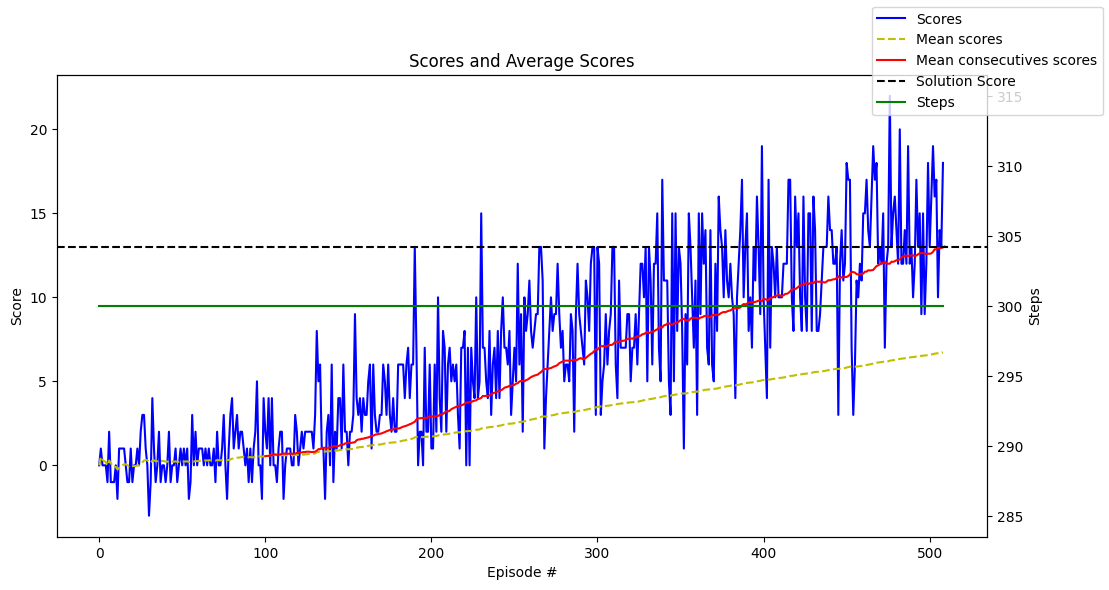

In [37]:
plot_scores(scores, mean_scores, mean_consecutive_scores, solution_score, stats_episodes, scores_window_length, "Scores and Average Scores")

## Test

In [7]:
reload = True
if reload:
    agent = DQNAgentReplay (
        state_size=brain.vector_observation_space_size,
        action_size=brain.vector_action_space_size,
        model_parameters=model_parameters,
        device=device,
        seed=SEED
        )
    agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth', weights_only=True))
    agent.qnetwork_local.to(device)

In [ ]:
consecutive_successful_episodes_count = 100
test_scores = []
max_steps = 1000

for i_episode in trange(1, consecutive_successful_episodes_count+1):
    env_info = env.reset(train_mode=False)[brain_name]
    state = env_info.vector_observations[0]
    
    score = 0    
    done = False
    steps = 0
    while not done:
        # Agent chooses action
        action = agent.act(state)
        
        # Apply action to environment
        env_info = env.step(action)[brain_name]
        
        # Get environment evolution as experience : next state, reward and done
        next_state = env_info.vector_observations[0]
        reward = env_info.rewards[0]
        done = env_info.local_done[0]

        score += reward                                # update the score
        steps += 1
        done = done or steps >= max_timesteps

        state = next_state                             # roll over the state to next time step

    test_scores.append(score)
    
    print(f"Episode {i_episode} Score: {score} | Mean: {np.mean(test_scores):.2f}", end="")

I0000 00:00:1742666572.417661  211615 fork_posix.cc:75] Other threads are currently calling into gRPC, skipping fork() handlers


  0%|          | 0/99 [00:00<?, ?it/s]

Episode 99 Score: 22.0 | Mean: 14.242424242424242

In [11]:
print(f"Mean scores : {np.mean(test_scores):.2f}")

Mean scores : 14.24


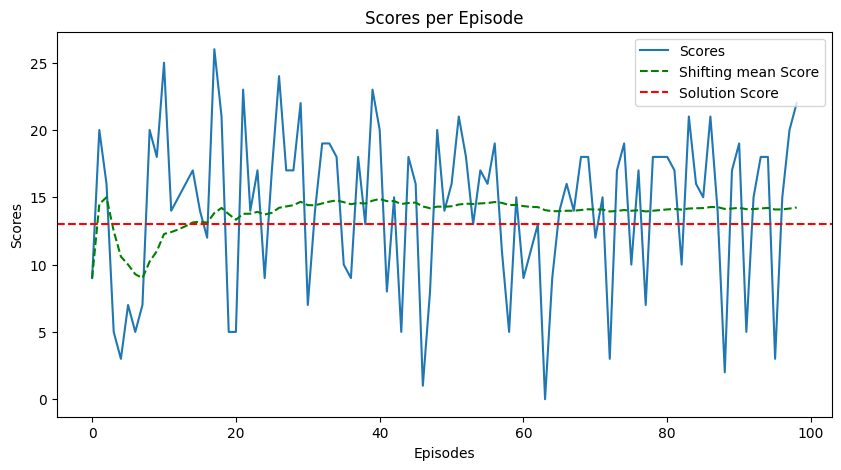

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(test_scores, label='Scores')
shifting_mean_scores = [np.mean(test_scores[:i+1]) for i in range(len(test_scores))]
plt.plot(shifting_mean_scores, color='g', linestyle='--', label='Shifting mean Score')
plt.axhline(y=solution_score, color='r', linestyle='--', label='Solution Score')
plt.xlabel('Episodes')
plt.ylabel('Scores')
plt.title('Scores per Episode')
plt.legend()
plt.show()

## End closing Unity env

In [20]:
env.close()